## Classification experiment - Review Polarity

This week we have 3 delivarables:
- A `.py` file that finds the best model's hyperparameters;
- The `.csv` file with best hyperparameters finded;
- A `.ipynb` file that shows the best hyperparameters finded and the final metrics for the text classification experiment.

This notebook aims to find the best model to compete against MultinomialNB and LogisticRegression - models selected by the professor. The data used here is available in the [Text Collections](https://github.com/ragero/text-collections/tree/master/complete_texts_csvs) Github repo. I chose an arbitrary dataset for this first experiment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

### Data

In [3]:
df = pd.read_csv("text_databases/review_polarity.csv")
df

,file_name,text,class
0,cv145_12239.txt,it was once said that in order to truly enjoy ...,neg
1,cv745_14009.txt,conventional wisdom among collectibles retaile...,neg
2,cv376_20883.txt,robin williams has the rarest of gifts : the a...,neg
3,cv109_22599.txt,nearly every film tim burton has directed has ...,neg
4,cv494_18689.txt,"you know , i never really wondered what the ta...",neg
...,...,...,...
1995,cv964_6021.txt,you've got to think twice before you go see a ...,pos
1996,cv989_15824.txt,"lisa cholodenko's "" high art , "" is an intelli...",pos
1997,cv355_16413.txt,to paraphrase a song title from an earlier dis...,pos
1998,cv463_10343.txt,one fun activity for parents during the holida...,pos


In [4]:
df.fillna('', inplace=True)
df

,file_name,text,class
0,cv145_12239.txt,it was once said that in order to truly enjoy ...,neg
1,cv745_14009.txt,conventional wisdom among collectibles retaile...,neg
2,cv376_20883.txt,robin williams has the rarest of gifts : the a...,neg
3,cv109_22599.txt,nearly every film tim burton has directed has ...,neg
4,cv494_18689.txt,"you know , i never really wondered what the ta...",neg
...,...,...,...
1995,cv964_6021.txt,you've got to think twice before you go see a ...,pos
1996,cv989_15824.txt,"lisa cholodenko's "" high art , "" is an intelli...",pos
1997,cv355_16413.txt,to paraphrase a song title from an earlier dis...,pos
1998,cv463_10343.txt,one fun activity for parents during the holida...,pos


### Model exploration

I made some helper functions to quickly retrieve me a text classification experiment:
- In the folder `utils`, we have two functions:
    - `custom_cls`: fits a given model or pipeline and keeps track of performance metrics and elapsed time;
    - `get_cls_results`: a function that calls `custom_cls` and prints the metrics of the current using classification_report and a confusion matrix.

I also made some preprocessing transformers. All classes inherit from sklearn `TransformerMixin` and `BaseEstimator`. We have transformers for removing stopwords, for stemming, and also for lemmatization.

In [5]:
from preprocessing import StopwordsTransformer, StemmerTransformer, LemmatizerTransformer
from utils import get_cls_results

I usually choose a model for each 'category' of models:
- SVC is often a good baseline, both using the RBF and the linear kernels;
- A DecisionTree is also a good baseline for tree methods;
- Ensemble methods are also useful, so getting XGBoost or LightGBM is also a nice starting point;
- For linear methods, I generally took the LogisticRegression, but as this model is one the choices for the final experiment I got the RidgeClassifier instead.

To vectorize the text, I use the main Bag of Words methods available in sklearn:
- CountVectorizer
- TF-IDF
- HashingVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier

In [7]:
# LGBM asks for float values, default of CountVectorizer is int64
cv_vec = CountVectorizer(dtype=np.float64)
tfidf_vec = TfidfVectorizer()
hash_vec = HashingVectorizer()

svc_model = SVC(random_state=14)
svc_linear_model = SVC(kernel='linear', max_iter=10000, random_state=14)
# lgbm talks a bit too much; verbose=-1 suppresses most of it
lgbm = LGBMClassifier(objective="binary", verbose=-1, random_state=14)
dt_model = DecisionTreeClassifier(random_state=14)
ridge = RidgeClassifier(random_state=14)

In [8]:
models_reprs = {
    'models': [svc_model, svc_linear_model, lgbm, dt_model, ridge],
    'vectorizers': [cv_vec, tfidf_vec, hash_vec]
}

The helper function `custom_cls`, called within the function `get_cls_results`, receives a dataframe like this one below to track the models' scores.

In [9]:
results = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Time elapsed'])

Split made according the given exercise instructions, using a 80-20 ratio for train and test data.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'],
                                                    test_size=0.2, random_state=14,
                                                    stratify=df['class'])

split_data = [X_train, X_test, y_train, y_test]

### Classification without preprocessing steps

In [11]:
from sklearn.pipeline import Pipeline
import time

SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.71      0.81      0.76       200
         pos       0.78      0.66      0.72       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



/home/user/unb/unb_mestrado/2_semestre/topicos_nlp/nlp/atividade_3/utils.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([results, row])


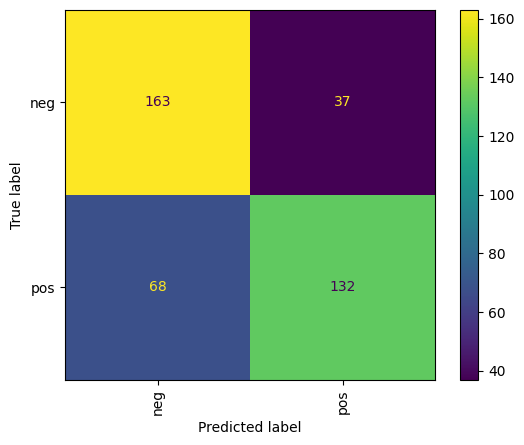

--- 14.53336477279663 seconds ---
SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.81      0.81       200
         pos       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



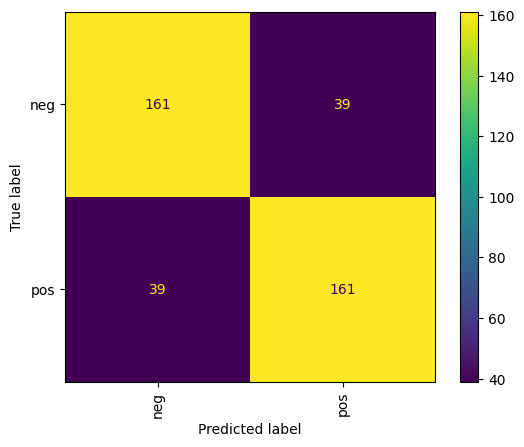

--- 17.459285020828247 seconds ---
SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.79      0.79      0.79       200
         pos       0.79      0.79      0.79       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



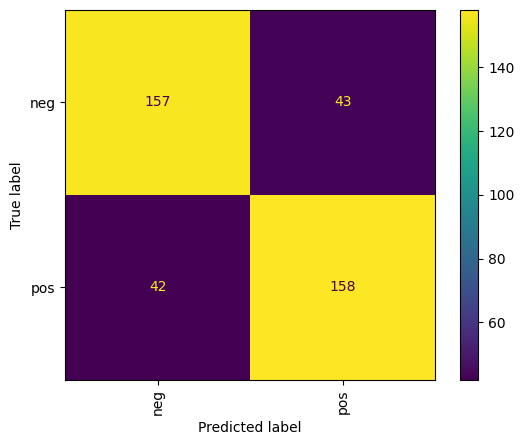

--- 9.46653413772583 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.79      0.86      0.82       200
         pos       0.85      0.77      0.81       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



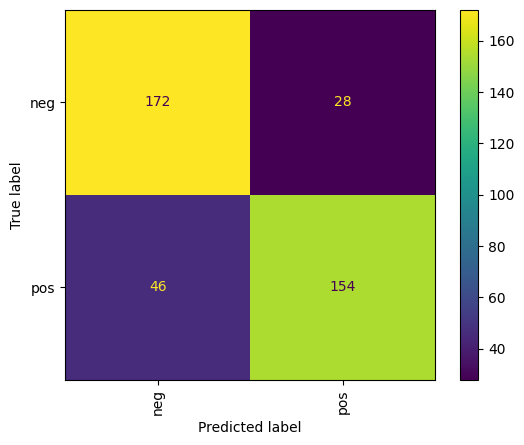

--- 8.979973316192627 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.82      0.81      0.82       200
         pos       0.82      0.82      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



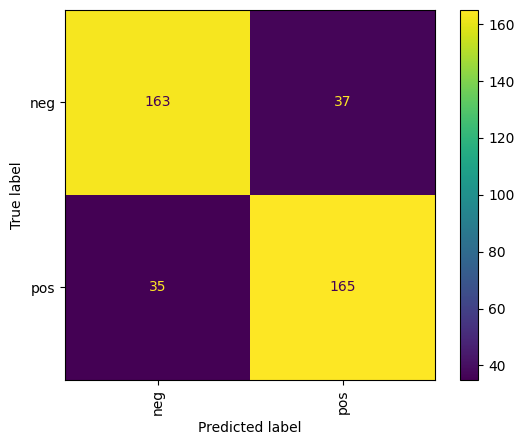

--- 10.42512321472168 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.78      0.74      0.76       200
         pos       0.76      0.80      0.78       200

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



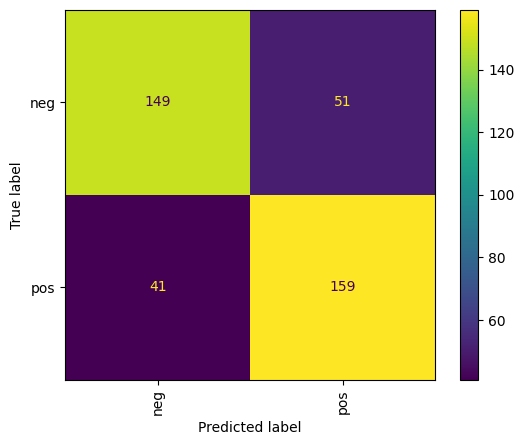

--- 9.762903928756714 seconds ---
LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.86      0.84      0.85       200
         pos       0.85      0.86      0.86       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



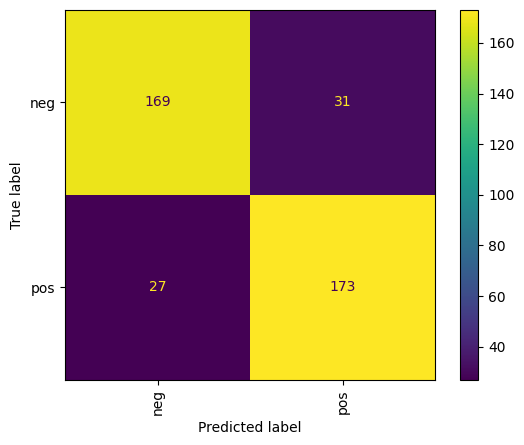

--- 1.9963014125823975 seconds ---
LGBMClassifier(objective='binary', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.80      0.81       200
         pos       0.80      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



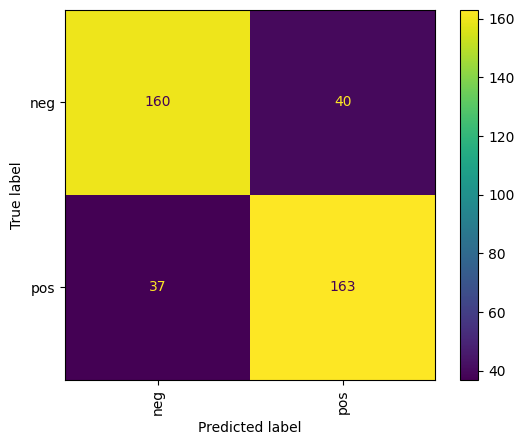

--- 4.004006624221802 seconds ---
LGBMClassifier(objective='binary', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82       200
         pos       0.83      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



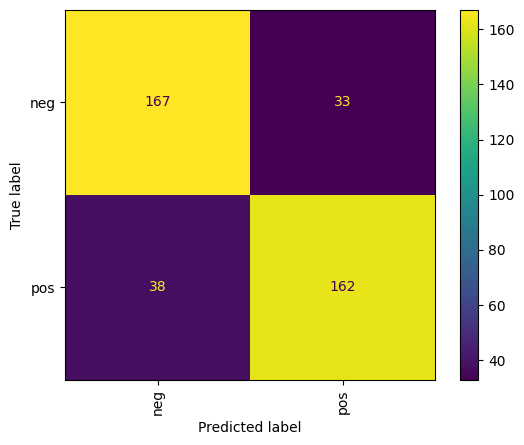

--- 8.037206172943115 seconds ---
DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.67      0.67      0.67       200
         pos       0.67      0.67      0.67       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67       400



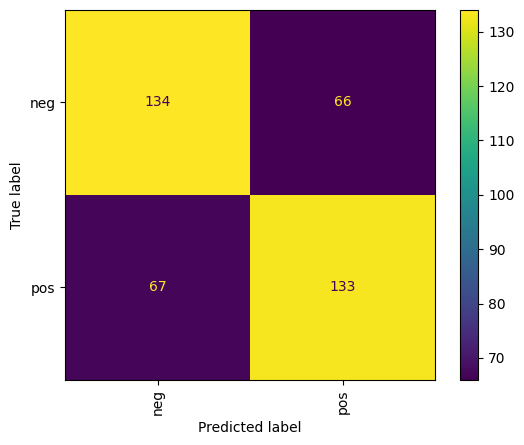

--- 2.081397771835327 seconds ---
DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.62      0.63      0.62       200
         pos       0.62      0.61      0.62       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



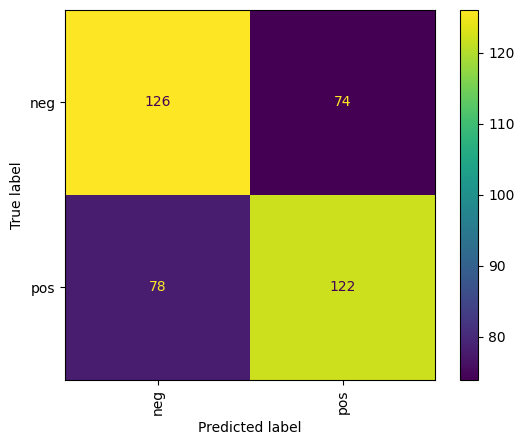

--- 2.826500415802002 seconds ---
DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.68      0.69      0.69       200
         pos       0.69      0.67      0.68       200

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



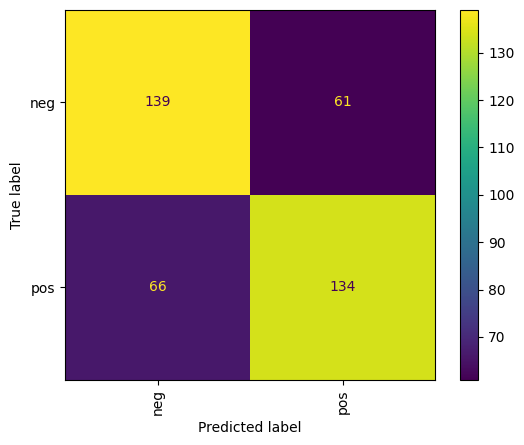

--- 5.465953588485718 seconds ---
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.78      0.83      0.80       200
         pos       0.82      0.77      0.79       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



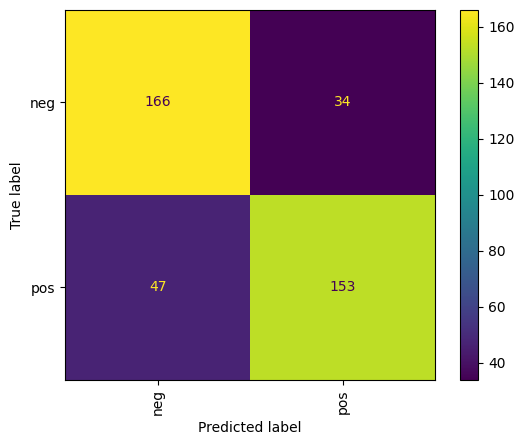

--- 2.7955572605133057 seconds ---
RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.83      0.81      0.82       200
         pos       0.82      0.83      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



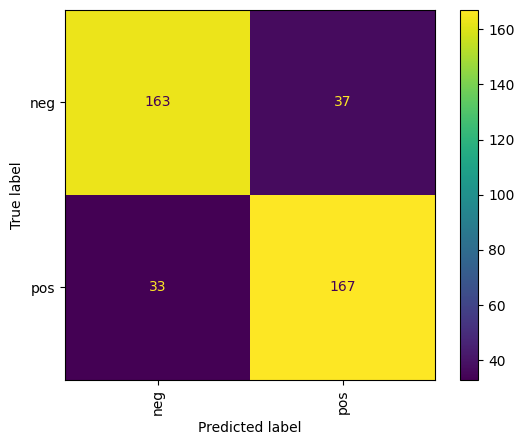

--- 1.205996036529541 seconds ---
RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.81      0.81       200
         pos       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



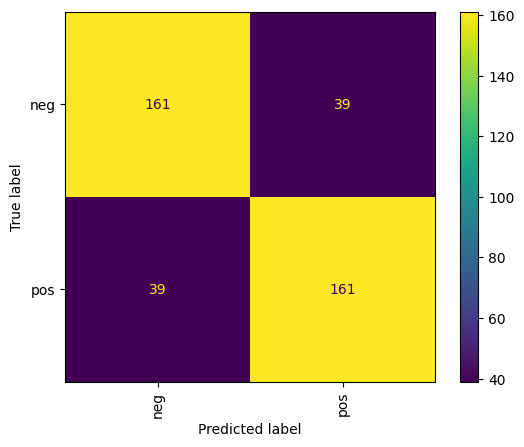

--- 1.5592176914215088 seconds ---


In [12]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[
            ('feature_extraction', vect),
            ('model', model)
        ])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [13]:
results

,Precision,Recall,F1-Score,Time elapsed
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)",0.855142,0.8550,0.854985,1.868361
RidgeClassifier(random_state=14) TfidfVectorizer(),0.825130,0.8250,0.824982,1.043489
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) HashingVectorizer()",0.822702,0.8225,0.822472,7.916578
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.820032,0.8200,0.819995,10.318230
"SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)",0.817572,0.8150,0.814625,8.874073
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) TfidfVectorizer()",0.807569,0.8075,0.807489,3.886828
SVC(random_state=14) TfidfVectorizer(),0.805000,0.8050,0.805000,17.352819
RidgeClassifier(random_state=14) HashingVectorizer(),0.805000,0.8050,0.805000,1.416397
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.798762,0.7975,0.797286,2.665912
SVC(random_state=14) HashingVectorizer(),0.787507,0.7875,0.787499,9.361929


### Preprocessing experiment

Same experiment, but now with some combinations of preprocessing.

In [14]:
pre_processing_pipe_all = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en")),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_lemma = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en"))
    ]
)

pre_processing_pipe_stop_stem = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_only = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"]))
    ]
)

All Preprocs - SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.77      0.81      0.79       200
         pos       0.80      0.76      0.78       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



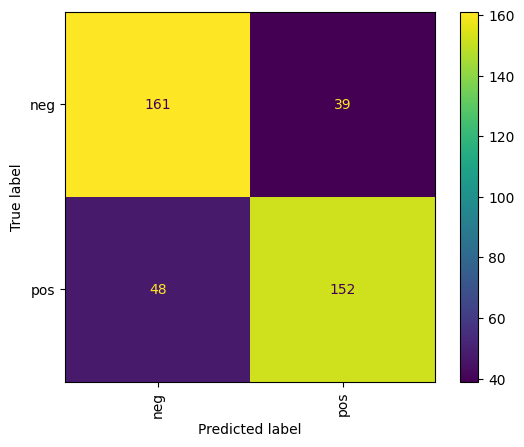

--- 21.811910152435303 seconds ---
All Preprocs - SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.79      0.81      0.80       200
         pos       0.80      0.79      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



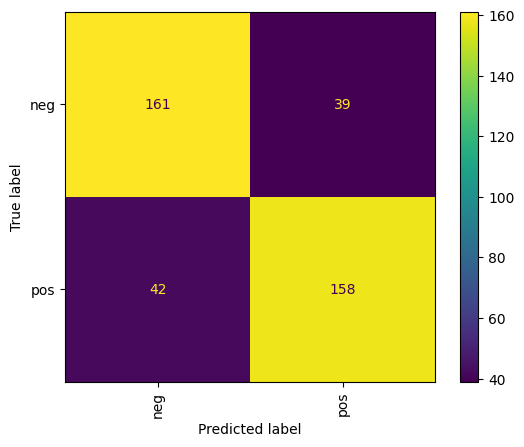

--- 24.690597772598267 seconds ---
All Preprocs - SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.82      0.78      0.79       200
         pos       0.79      0.82      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



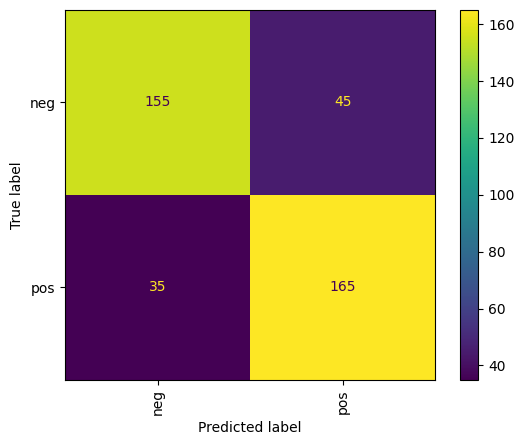

--- 23.95218539237976 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.83      0.82      0.83       200
         pos       0.83      0.83      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



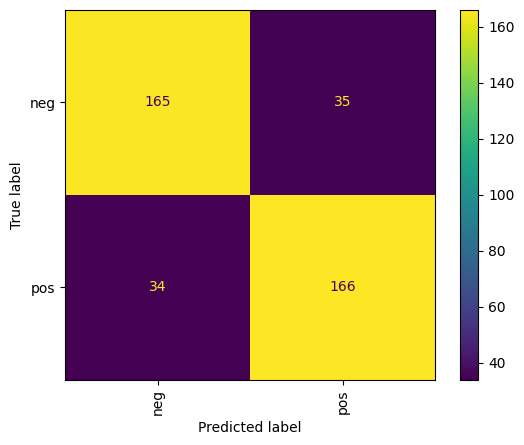

--- 19.4835946559906 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.81      0.81       200
         pos       0.81      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



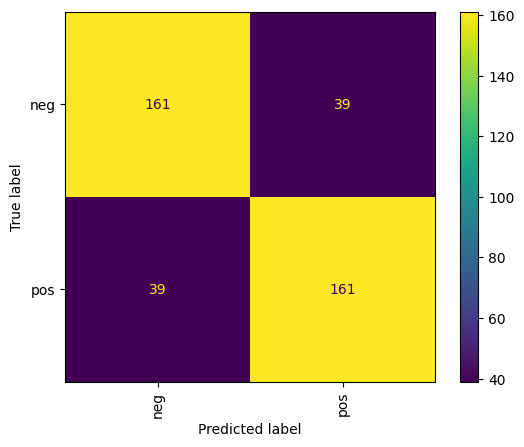

--- 23.96119475364685 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.84      0.80      0.82       200
         pos       0.81      0.85      0.83       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



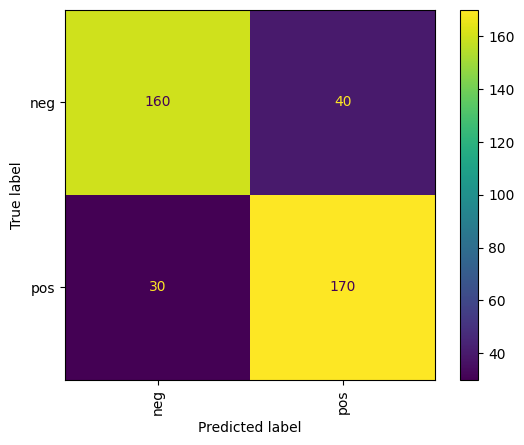

--- 28.106351613998413 seconds ---
All Preprocs - LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.83      0.81      0.82       200
         pos       0.82      0.83      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



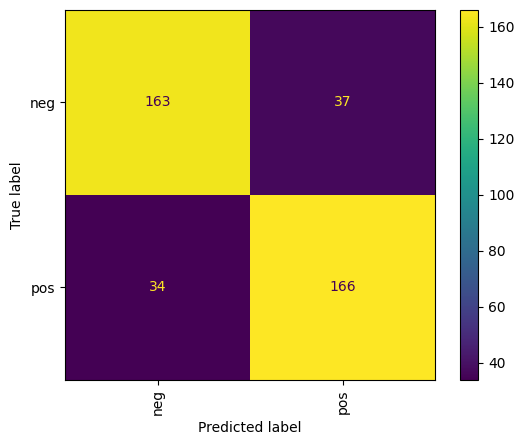

--- 13.450103759765625 seconds ---
All Preprocs - LGBMClassifier(objective='binary', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.80      0.80      0.80       200
         pos       0.80      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



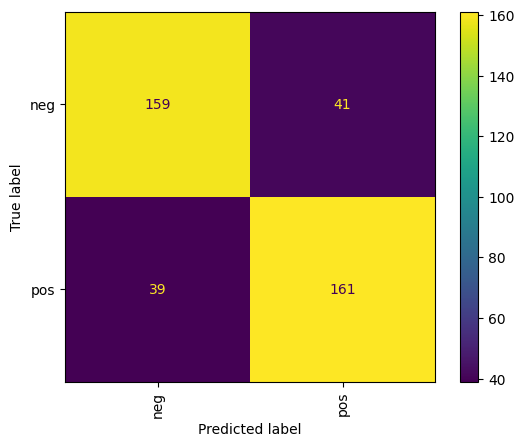

--- 15.316405534744263 seconds ---
All Preprocs - LGBMClassifier(objective='binary', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.79      0.79       200
         pos       0.79      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



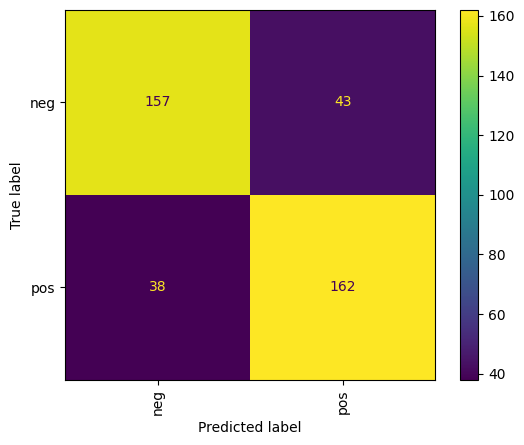

--- 19.189943313598633 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.72      0.66      0.69       200
         pos       0.68      0.74      0.71       200

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



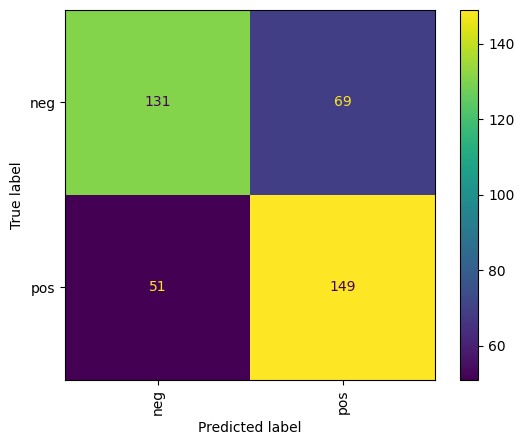

--- 13.36082410812378 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.62      0.61      0.62       200
         pos       0.62      0.62      0.62       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



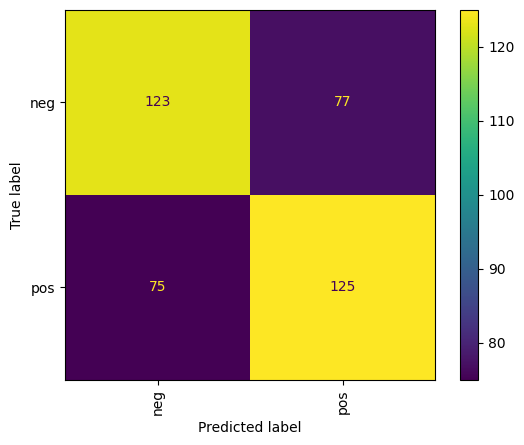

--- 13.777453184127808 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.63      0.61      0.62       200
         pos       0.62      0.64      0.63       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



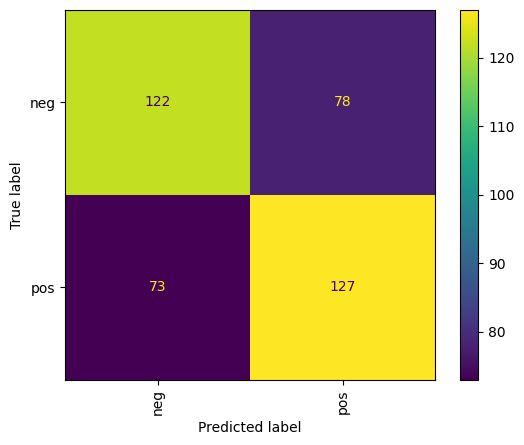

--- 21.880968809127808 seconds ---
All Preprocs - RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

         neg       0.78      0.79      0.78       200
         pos       0.78      0.78      0.78       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



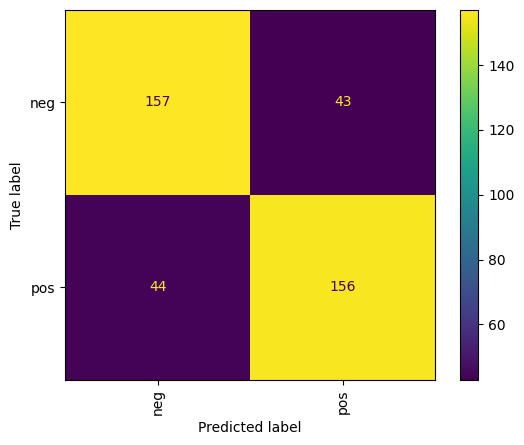

--- 15.587853193283081 seconds ---
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

         neg       0.81      0.80      0.80       200
         pos       0.80      0.81      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



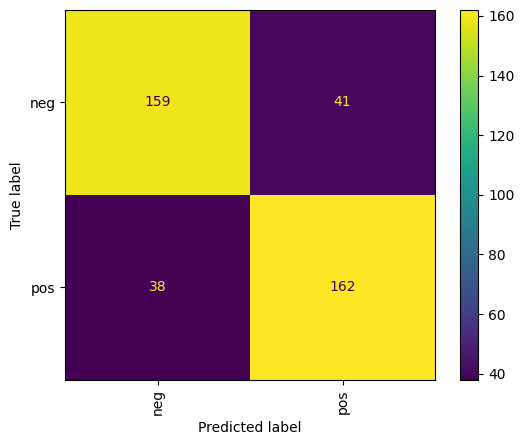

--- 13.271577596664429 seconds ---
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

         neg       0.83      0.81      0.82       200
         pos       0.81      0.83      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



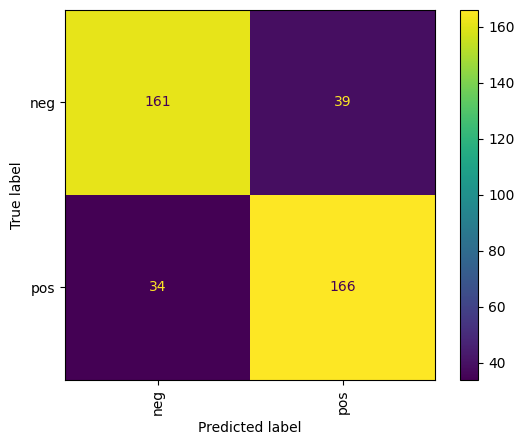

--- 13.367892265319824 seconds ---


In [15]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'All Preprocs - ' + str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_all),
                               ('vectorizer', vect),
                               ('model', model)])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
results

,Precision,Recall,F1-Score,Time elapsed
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)",0.855142,0.8550,0.854985,1.868361
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)",0.827508,0.8275,0.827499,19.368121
RidgeClassifier(random_state=14) TfidfVectorizer(),0.825130,0.8250,0.824982,1.043489
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.825815,0.8250,0.824891,27.994547
"All Preprocs - LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)",0.822573,0.8225,0.822490,13.336126
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) HashingVectorizer()",0.822702,0.8225,0.822472,7.916578
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.820032,0.8200,0.819995,10.318230
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer(),0.817699,0.8175,0.817471,13.245247
"SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)",0.817572,0.8150,0.814625,8.874073
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) TfidfVectorizer()",0.807569,0.8075,0.807489,3.886828


LGBM without preprocessing still on top! Let's compute the other compositions of preprocessing pipelines to discover the winner.

In [17]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Lemmatization - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_lemma),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Stemmer - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_stem),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Only Stopwords - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_only),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
results

,Precision,Recall,F1-Score,Time elapsed
"LGBMClassifier(objective='binary', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)",0.855142,0.8550,0.854985,1.868361
"Stopwords and Lemmatization - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.835302,0.8350,0.834963,9.235131
Stopwords and Lemmatization - RidgeClassifier(random_state=14) HashingVectorizer(),0.833175,0.8325,0.832415,2.847659
Only Stopwords - RidgeClassifier(random_state=14) HashingVectorizer(),0.830529,0.8300,0.829932,2.040370
"Only Stopwords - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.830827,0.8300,0.829894,6.392309
...,...,...,...,...
All Preprocs - DecisionTreeClassifier(random_state=14) HashingVectorizer(),0.622577,0.6225,0.622441,21.720874
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.620012,0.6200,0.619990,13.671361
DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.620048,0.6200,0.619962,2.720626
Stopwords and Lemmatization - DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.615741,0.6150,0.614383,3.680192


LGBM wins! The model had the best metric scores and one of the best time consumptions. We also had two possibilities using the Ridge Classifier and preprocessing that are competitive ones; the runner up, omy beloved Linear SVM, had also a good score, but falls back when we look for the time elapsed.